<font size="6"> **ML-Sentiment Factor in SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import datetime as dt

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [5]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

from sklearn import metrics

In [6]:
cfg = utils.read_conf()

In [7]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
os.path.isdir(INPATH1), os.path.isdir(INPATH2)

(True, True)

In [8]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']
INFILE7 = cfg['output']['interim']['pricing']

In [9]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [10]:
OUTFILE1 = 'sec_10k_mlbow_sent_alpha.csv'

In [11]:
example_ticker = 'amzn'

In [12]:
START_DT = '1998'
END_DT = '2018'
train_test_split_yr = '2016'
KFOLDS = 3
RND_SEED = 123

# Load Data

## Corpus Data

In [13]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [14]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [15]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [16]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [17]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [18]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

## Sentiemnts Metadata

In [19]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

## Prices

In [20]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [21]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [22]:
# Daily pricing
pricing = pd.read_csv(io_utils.interim_path + INFILE7, parse_dates=['date'], index_col='date')
pricing.index = pricing.index.tz_convert(tz=None)

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Sector Metadata 

In [23]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [24]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [25]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [26]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')
sector_to_asset.index = pd.Index([x.lower() for x in sector_to_asset.index], name='ticker')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
ticker,,
a,0,Healthcare
aal,3,Industrials
hpe,1,Technology
csra,1,Technology


# Data Preparation

## Compute TF-IDF matrix based on Loughran Mcdonald textual analysis in financial data

In [27]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [28]:
sentiment_df.shape # complete vocab size

(2719, 7)

In [29]:
word_vocab = pd.Series(index=sentiment_df['word'].values, data=sentiment_df.sum(axis=1).values )
word_vocab[word_vocab>1]  # tokens that appear in more than one sentiment

abrogate       2
abrogation     2
abrogations    2
acquit         2
acquittal      2
              ..
violative      2
void           2
volatile       2
volatility     2
willfully      2
Length: 144, dtype: int64

In [30]:
tfidf = bow_sent.get_combined_tfidf(tf_idf_by_sent)
tfidf['date_filling'] = tfidf.index.get_level_values('date')
tfidf.index = pd.MultiIndex.from_tuples([(ticker, dt.date(year=date.year, month=1, day=1)) for ticker, date in tfidf.index], names=tfidf.index.names )

pd.concat([tfidf.head(2), tfidf.tail(2)], axis=0)

Number of removed words:
uncertainty: 32
litigious: 95
constraining: 18
interesting: 2


abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                    
aal    2003-01-01  0.000000     0.000000           0.0       0.0         0.0   
       2004-01-01  0.000000     0.000000           0.0       0.0         0.0   
zts    2019-01-01  0.012278     0.013347           0.0       0.0         0.0   
       2020-01-01  0.013254     0.014408           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-01-01          0.0       0.0         0.0           0.0   
       2004-01-01          0.0       0.0         0.0           0.0   
zts    2019-01-01          0.0       0.0         0.0           0.0   
       2020-01-01          0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
ticker date                                                                  
aal    2003-01-01          0.0   0.0       0.0            0.0          0.0   
       2004-01-01          0.0   0.0       0.0            0.0          0.0   
zts    2019-01-01          0.0   0.0       0.0            0.0          0.0   
       2020-01-01          0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
ticker date                                                                 
aal    2003-01-01         0.0      0.0       0.0         0.0          0.0   
       2004-01-01         0.0      0.0       0.0         0.0          0.0   
zts    2019-01-01         0.0      0.0       0.0         0.0          0.0   
       2020-01-01         0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
ticker date                                                           
aal    2003-01-01     0.0       0.0         0.0  0.033477       0.0   
       2004-01-01     0.0       0.0         0.0  0.000000       0.0   
zts    2019-01-01     0.0       0.0         0.0  0.000000       0.0   
       2020-01-01     0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...     march  mighty  mortgagee  oink  \
ticker date                     ...                                      
aal    2003-01-01          0.0  ...  0.315236     0.0        0.0   0.0   
       2004-01-01          0.0  ...  0.385279     0.0        0.0   0.0   
zts    2019-01-01          0.0  ...  0.173299     0.0        0.0   0.0   
       2020-01-01          0.0  ...  0.184606     0.0        0.0   0.0   

                   piracy  rabbi  reductions   relieve  remedial  repossess  \
ticker date                                                                   
aal    2003-01-01     0.0    0.0    0.183164  0.000000  0.097192        0.0   
       2004-01-01     0.0    0.0    0.264436  0.000000  0.000000        0.0   
zts    2019-01-01     0.0    0.0    0.017230  0.000000  0.000000        0.0   
       2020-01-01     0.0    0.0    0.021107  0.028421  0.000000        0.0   

                   secret  seizures  soar  sputter  sublessee  sublessees  \
ticker date                                                                 
aal    2003-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2004-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
zts    2019-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2020-01-01     0.0       0.0   0.0      0.0        0.0         0.0   

                   sublessor  suspenders  sustainability  touche  toxic  \
ticker date                                                               
aal    2003-01-01        0.0         0.0             0.0     0.0    0.0   
       2004-01-01        0.0         0.0             0.0     0.0    0.0   
zts    2019-01-01        0.0         0.0             0.0     0.0    0.0   
 

In [31]:
tfidf.shape

(8637, 2720)

## Targets

In [32]:
def compute_fwd_targets(prices, tau, name, index_name='ticker'):
    prices_cp = prices.copy()
    prices_cp.columns = [x.lower() for x in prices_cp.columns]
    targets = ( (prices_cp.shift(-tau).subtract(prices_cp)).div(prices_cp) ).stack()
    targets.name = name
    targets.index.rename(inplace=True, level=1, names=index_name)
    
    return targets

### Long Term Target

In [33]:
pricing_yr.columns = [x.lower() for x in pricing_yr.columns]
targets_yr = compute_fwd_targets(pricing_yr, tau=1, name='1yr_fwd_rets').loc[pd.Timestamp(START_DT):]

targets_yr.sample(5)

date        ticker
2005-01-01  arw      -0.014986
1998-01-01  gib       1.161030
2015-01-01  hwkn      0.540616
2011-01-01  dxd      -0.219791
2003-01-01  pnrg      0.428474
Name: 1yr_fwd_rets, dtype: float64

In [34]:
aapl_prices = pricing_yr.loc['2017':'2018', 'aapl']
aapl_prices

date
2017-01-01    167.90118
2018-01-01    185.40000
Name: aapl, dtype: float64

In [35]:
aapl_ret_2017 = (aapl_prices.iloc[-1] - aapl_prices.iloc[0]) / aapl_prices.iloc[0]
aapl_ret_2017

0.10422094647492033

In [36]:
np.isclose(aapl_ret_2017, (pricing_yr.loc['2018', 'aapl'].values - pricing_yr.loc['2017', 'aapl'].values) / pricing_yr.loc['2017', 'aapl'].values)

array([ True])

In [37]:
np.isclose(aapl_ret_2017, targets_yr.loc[pd.Timestamp('2017'), 'aapl'])

True

In [38]:
pricing_yr.pct_change(-1).loc['2017', 'aapl']

date
2017-01-01   -0.094384
Name: aapl, dtype: float64

### Short term targets

In [39]:
targets_st = compute_fwd_targets(pricing, tau=5, name='5d_fwd_rets').to_frame()
targets_st['20d_fwd_rets'] = compute_fwd_targets(pricing, tau=5, name='20d_fwd_rets')

targets_st.sample(4)

,,5d_fwd_rets,20d_fwd_rets
date,ticker,,
2011-08-23,eqt,0.074906,0.074906
2013-04-08,wba,0.020137,0.020137
2013-02-20,exc,0.016502,0.016502
2012-05-31,hrb,0.022961,0.022961


In [40]:
join_cols = ['date', 'ticker']
tfidf_targets = tfidf.merge(targets_yr, how='inner', on=join_cols).sort_index()

pd.concat([tfidf_targets.head(2), tfidf_targets.tail(2)], axis=0)

abandon  abandonment  abandonments  abdicate  abdication  \
date       ticker                                                              
1998-01-01 abt     0.000000     0.000000           0.0       0.0         0.0   
           adbe    0.000000     0.000000           0.0       0.0         0.0   
2017-01-01 zion    0.000000     0.000000           0.0       0.0         0.0   
           zts     0.010714     0.011646           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
date       ticker                                                    
1998-01-01 abt             0.0       0.0         0.0           0.0   
           adbe            0.0       0.0         0.0           0.0   
2017-01-01 zion            0.0       0.0         0.0           0.0   
           zts             0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
date       ticker                                                            
1998-01-01 abt             0.0   0.0       0.0            0.0          0.0   
           adbe            0.0   0.0       0.0            0.0          0.0   
2017-01-01 zion            0.0   0.0       0.0            0.0          0.0   
           zts             0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
date       ticker                                                           
1998-01-01 abt            0.0      0.0       0.0         0.0          0.0   
           adbe           0.0      0.0       0.0         0.0          0.0   
2017-01-01 zion           0.0      0.0       0.0         0.0          0.0   
           zts            0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
date       ticker                                                     
1998-01-01 abt        0.0       0.0         0.0  0.000000       0.0   
           adbe       0.0       0.0         0.0  0.000000       0.0   
2017-01-01 zion       0.0       0.0         0.0  0.018155       0.0   
           zts        0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...  mighty  mortgagee  oink  piracy  \
date       ticker               ...                                    
1998-01-01 abt             0.0  ...     0.0        0.0   0.0     0.0   
           adbe            0.0  ...     0.0        0.0   0.0     0.0   
2017-01-01 zion            0.0  ...     0.0        0.0   0.0     0.0   
           zts             0.0  ...     0.0        0.0   0.0     0.0   

                      rabbi  reductions  relieve  remedial  repossess  secret  \
date       ticker                                                               
1998-01-01 abt     0.000000    0.000000      0.0       0.0        0.0     0.0   
           adbe    0.000000    0.034246      0.0       0.0        0.0     0.0   
2017-01-01 zion    0.012734    0.027760      0.0       0.0        0.0     0.0   
           zts     0.000000    0.048960      0.0       0.0        0.0     0.0   

                   seizures  soar  sputter  sublessee  sublessees  sublessor  \
date       ticker                                                              
1998-01-01 abt          0.0   0.0      0.0        0.0         0.0        0.0   
           adbe         0.0   0.0      0.0        0.0         0.0        0.0   
2017-01-01 zion         0.0   0.0      0.0        0.0         0.0        0.0   
           zts          0.0   0.0      0.0        0.0         0.0        0.0   

                   suspenders  sustainability  touche  toxic  trauma  tumor  \
date       ticker                                                             
1998-01-01 abt            0.0             0.0     0.0    0.0     0.0    0.0   
           adbe           0.0             0.0     0.0    0.0     0.0    0.0   
2017-01-01 zion           0.0             

In [41]:
date_filling = tfidf_targets.pop('date_filling')

In [42]:
tfidf_targets_st = tfidf.merge(targets_st, how='inner', left_on=['date_filling', 'ticker'],
                               right_on=['date', 'ticker']).\
    reset_index().set_index(['date_filling', 'ticker']).sort_index()

pd.concat([tfidf_targets_st.head(2), tfidf_targets_st.tail(2)], axis=0)

,,abandon,abandonment,abandonments,abdicate,abdication,abdications,aberrant,aberration,aberrational,aberrations,abet,abnormal,abnormalities,abnormality,abnormally,abolish,abrogate,abrogation,abrogations,abrupt,abruptly,abruptness,absence,absences,absenteeism,...,mighty,mortgagee,oink,piracy,rabbi,reductions,relieve,remedial,repossess,secret,seizures,soar,sputter,sublessee,sublessees,sublessor,suspenders,sustainability,touche,toxic,trauma,tumor,vacant,5d_fwd_rets,20d_fwd_rets
date_filling,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-26,dfs,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.007056,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.004121,0.000000,0.0,0.0,0.0,-0.006757,-0.006757
2011-01-27,adbe,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.083377,0.0,0.077702,0.000000,0.000000,0.0,0.036582,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-0.009453,-0.009453
2015-12-18,de,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00987,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.035581,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02826,0.047567,0.000000,0.0,0.0,0.0,0.040015,0.040015
2015-12-21,a,0.037755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.076734,0.000000,0.013783,0.0,0.000000,0.015569,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.080921,0.0,0.0,0.0,0.045782,0.045782


## Train/ Test Split

### Long-Term Targets

In [43]:
idx_train = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date < pd.Timestamp(train_test_split_yr)]))
idx_test = list(set([(date, ticker) for date, ticker in tfidf_targets.index if date >= pd.Timestamp(train_test_split_yr)]))

In [44]:
splits = pd.Series(index=idx_train + idx_test, data= ['train']*len(idx_train) + ['test']*len(idx_test))
splits.sample(2)

(2009-01-01 00:00:00, ual)     train
(2003-01-01 00:00:00, sbux)    train
dtype: object

In [45]:
X_train = tfidf_targets.loc[idx_train].drop(columns=['1yr_fwd_rets']).copy()
X_test = tfidf_targets.loc[idx_test].drop(columns=['1yr_fwd_rets']).copy()

In [46]:
print(X_train.shape, X_test.shape)

(6361, 2719) (893, 2719)


In [47]:
y_train = tfidf_targets.loc[idx_train, '1yr_fwd_rets'].copy()
y_test = tfidf_targets.loc[idx_test, '1yr_fwd_rets'].copy()

In [48]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    6361.000000
mean       -0.000314
std         1.414436
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [49]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    6361.000000
mean        0.703349
std         0.456817
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [50]:
print(y_train.shape, y_test.shape)

(6361,) (893,)


### Short-Term Targets

In [51]:
train_test_split_yr_st = '2014'

In [52]:
idx_train_st = list(set([(date, ticker) for date, ticker in tfidf_targets_st.index if date < pd.Timestamp(train_test_split_yr_st)]))
idx_test_st = list(set([(date, ticker) for date, ticker in tfidf_targets_st.index if date >= pd.Timestamp(train_test_split_yr_st)]))

In [53]:
splits_st = pd.Series(index=idx_train_st + idx_test_st, data=['train']*len(idx_train_st) + ['test']*len(idx_test_st))
splits_st.sample(2)

(2015-02-26 00:00:00, uhs)    test
(2014-02-18 00:00:00, vtr)    test
dtype: object

In [54]:
targets_cols_st = ['5d_fwd_rets' ,'20d_fwd_rets']
X_train_st = tfidf_targets_st.loc[idx_train_st].drop(columns=targets_cols_st).copy()
X_test_st = tfidf_targets_st.loc[idx_test_st].drop(columns=targets_cols_st).copy()

In [55]:
print(X_train_st.shape, X_test_st.shape)

(1265, 2719) (877, 2719)


In [56]:
y_train_5d = tfidf_targets_st.loc[idx_train_st, '5d_fwd_rets'].copy()
y_test_5d = tfidf_targets_st.loc[idx_test_st, '5d_fwd_rets'].copy()

y_train_20d = tfidf_targets_st.loc[idx_train_st, '20d_fwd_rets'].copy()
y_test_20d = tfidf_targets_st.loc[idx_test_st, '20d_fwd_rets'].copy()

### Target: Classification

In [57]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    6361.000000
mean       -0.000314
std         1.414436
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [58]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    6361.000000
mean        0.703349
std         0.456817
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [59]:
print(y_train.shape, y_test.shape)

(6361,) (893,)


In [60]:
y_train_5d_bin = (y_train_5d>=0).astype(int)
y_test_5d_bin = (y_test_5d>=0).astype(int)

y_train_20d_bin = (y_train_20d>=0).astype(int)
y_test_20d_bin = (y_test_20d>=0).astype(int)

# Model Build

In [61]:
#selection = SelectPercentile(mutual_info_classif)

## Target: 1yr

In [64]:
# Create the parameter dictionary
c_grid = [10.0**x for x in range(-4,3)]
alpha_grid = [10.0**x for x in range(-4,3)]
featselectk_grid = [25, 50, 100]

# Instanciate Models
nbc = MultinomialNB()
logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='saga', penalty='l1', max_iter=100)
logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', max_iter=100)

# Create parameter dictionar for every estimator
params1 = {}
#params1['featselector__percentile'] = featselectk_grid
params1['classifier__alpha'] =  c_grid
params1['classifier'] = [nbc]

params2 = {}
#params2['featselector__percentile'] = featselectk_grid
params2['classifier__C'] =  c_grid
params2['classifier'] = [logreg_l1]

params3 = {}
#params3['featselector__percentile'] = featselectk_grid
params3['classifier__C'] = c_grid
params3['classifier'] = [logreg_l2]

# create a list of parameter dictionaries
params = [params1, params2, params3]

In [66]:
# create the Pipeline
pipe = Pipeline([#('featselector', selection),
    ('classifier', nbc)])

# Fit hyperparameter CV grid search 
grid_cv = GridSearchCV(pipe, params, scoring=['accuracy', 'roc_auc'],
                    n_jobs=-1, refit='roc_auc',
                    cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_c))
grid_cv_res = grid_cv.fit(X_train, y_train_c)

In [108]:
def get_cv_summary(grid_cv_res):
    hparams = pd.DataFrame(grid_cv_res.cv_results_['params'])
    metrics = results_df = pd.DataFrame(grid_cv_res.cv_results_).filter(regex='(auc|mean_test_accuracy)')
    metrics['idx'] = metrics.index
    models = {nbc: 'nb', logreg_l1: 'logreg_l1', logreg_l2: 'logreg_l2' }
    hparams['classifier'] = hparams['classifier'].replace(models)
    
    return pd.concat([hparams, metrics], axis=1)

In [109]:
grid_cv_sum = get_cv_summary(grid_cv_res)
grid_cv_sum

,classifier,classifier__alpha,classifier__C,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
0,nb,0.0001,NaN,0.692243,0.521647,0.568277,0.545143,0.545022,0.019037,9,0
1,nb,0.0010,NaN,0.693711,0.522545,0.569505,0.543874,0.545308,0.019198,7,1
2,nb,0.0100,NaN,0.693711,0.524169,0.569108,0.541817,0.545031,0.018487,8,2
3,nb,0.1000,NaN,0.696226,0.527651,0.566531,0.541802,0.545328,0.016067,6,3
4,nb,1.0000,NaN,0.699581,0.534621,0.555663,0.543019,0.544434,0.008648,10,4
5,nb,10.0000,NaN,0.700210,0.514127,0.521140,0.526506,0.520591,0.005068,15,5
6,nb,100.0000,NaN,0.700210,0.506768,0.513056,0.519254,0.513026,0.005098,16,6
7,logreg_l1,NaN,0.0001,0.299790,0.500000,0.500000,0.500000,0.500000,0.000000,19,7
8,logreg_l1,NaN,0.0010,0.299790,0.500000,0.500000,0.500000,0.500000,0.000000,19,8
9,logreg_l1,NaN,0.0100,0.686373,0.506662,0.502575,0.486398,0.498545,0.008750,21,9


## Target: 20d

In [ ]:
nbc_20d = MultinomialNB()

nbc_20d_cv1 = GridSearchCV(nbc_20d, hpgrid_nb, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_nbc_20d_cv1 = nbc_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [ ]:
logreg_20d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, max_iter=1000)

logreg_20d_cv1 = GridSearchCV(logreg_20d, hpgrid_logreg, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_logreg_20d_cv1 = logreg_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [ ]:
pd.DataFrame(res_nbc_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

In [ ]:
pd.DataFrame(res_logreg_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

## Target: 5d

In [ ]:
nbc_5d = MultinomialNB()

nbc_5d_cv1 = GridSearchCV(nbc_5d, hpgrid_nb, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_nbc_5d_cv1 = nbc_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [ ]:
logreg_5d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, max_iter=1000)

logreg_5d_cv1 = GridSearchCV(logreg_5d, hpgrid_logreg, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_logreg_5d_cv1 = logreg_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [ ]:
pd.DataFrame(res_nbc_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

In [ ]:
pd.DataFrame(res_logreg_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

## From predictions to alpha factor

In [120]:
champ_mod = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='saga', penalty='l1', max_iter=500, C=10, n_jobs=-1)
champ_mod.fit(X_train, y_train_c)  # slightly higher mean AUC but much lower std dev score
champ_mod.classes_

C:\Users\manua\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


array([0, 1])

In [121]:
p_train = pd.Series(index=X_train.index, data=champ_mod.predict_proba(X_train)[:,1], name='sentiment_score')
p_test = pd.Series(index=X_test.index, data=champ_mod.predict_proba(X_test)[:,1], name='sentiment_score')

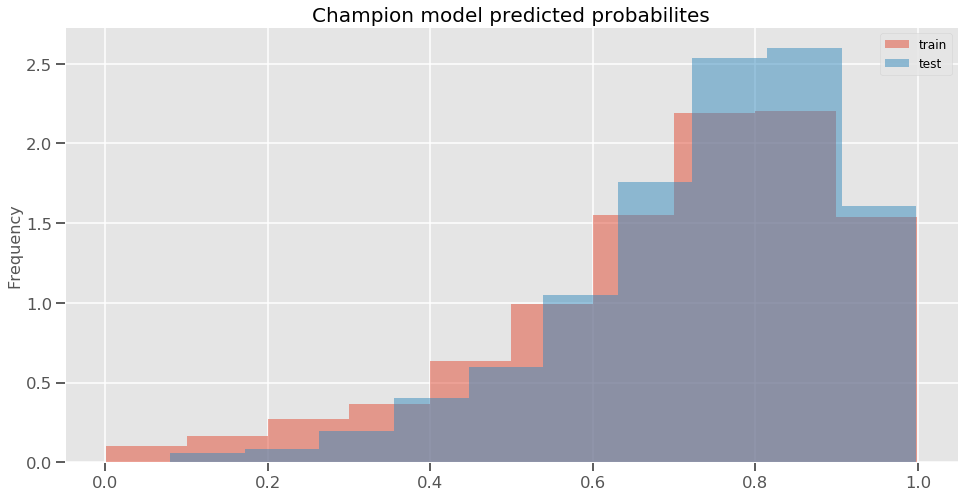

In [122]:
ax = p_train.plot.hist(density=True, alpha=0.5, label='train')
p_test.plot.hist(density=True, alpha=0.5, label='test', ax=ax)
plt.title("Champion model predicted probabilites")
plt.legend()
plt.show()

In [123]:
preds = pd.concat([p_train, p_test], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date', 'ticker']).sort_index()
preds['sector_code'] = preds['sector_code'].fillna(-1)
preds['sector'] = preds['sector'].fillna("No sector")

In [124]:
sent_alphas = bow_sent.compute_sentiment_alpha_factor(sent_scores=preds, date_col='date', sector_col='sector_code', score_col='sentiment_score').\
    to_frame()
sent_alphas['split'] = splits
sent_alphas['date_filling'] = date_filling

sent_alphas = sent_alphas.sort_index()

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Assessment in test

In [125]:
grid_cv_sum.groupby('classifier')['mean_test_roc_auc'].apply(lambda x: np.sort(x)[-1])

classifier
logreg_l1    0.562300
logreg_l2    0.555010
nb           0.545328
Name: mean_test_roc_auc, dtype: float64

In [126]:
grid_cv_sum.sort_values(by=['classifier', 'rank_test_roc_auc']).groupby('classifier').first()

,classifier__alpha,classifier__C,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
classifier,,,,,,,,,,
logreg_l1,NaN,1.0,0.697484,0.527751,0.598791,0.560356,0.562300,0.029035,1,11
logreg_l2,NaN,1.0,0.690147,0.528007,0.579869,0.557156,0.555010,0.021227,2,18
nb,0.1,NaN,0.696226,0.527651,0.566531,0.541802,0.545328,0.016067,6,3


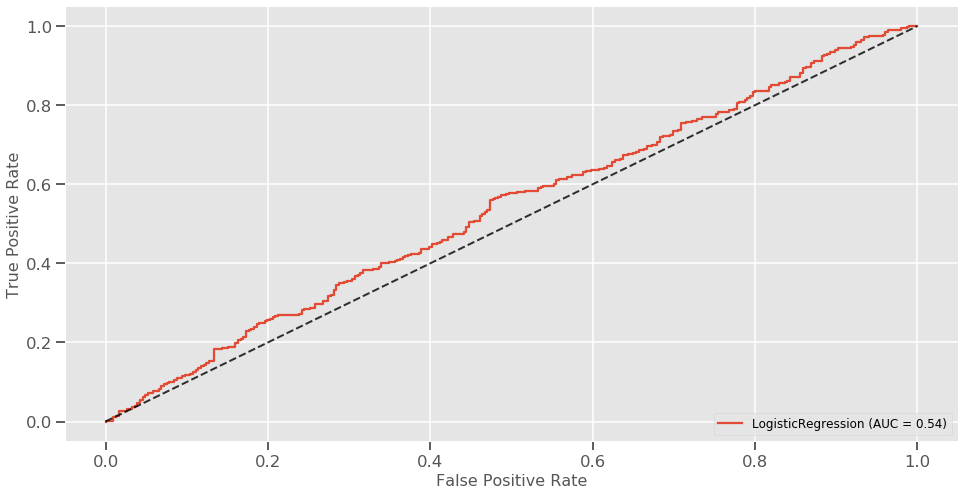

In [127]:
fig, ax = plt.subplots(1,1)

auroc_ax = metrics.plot_roc_curve(champ_mod, X_test, y_test_c, ax=ax)
#auroc_ax = metrics.plot_roc_curve(res_logreg_cv1.best_estimator_, X_test, y_test_c,  ax=ax)
#auroc_ax = metrics.plot_roc_curve(res_logreg_l1_cv1.best_estimator_, X_test, y_test_c,  ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
        label='Chance', alpha=.8)
plt.show()

In [ ]:
example = sent_alphas['sentiment_score']
ax = example.xs(key='amzn', level='ticker').plot()
example.xs(key='aapl', level='ticker').plot(ax=ax)
example.xs(key='msft', level='ticker').plot(ax=ax)
plt.show()

# Write Data

In [ ]:
sent_alphas.to_csv(OUTPATH + OUTFILE1)